In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

In [2]:
from os.path import join
import os

In [5]:
a = [1, 2, 3, 4, 5]
a[1:3]

[2, 3]

In [41]:
class config():
    # Hyperparameters
    batch_size = 16
    num_epochs = 20
    learning_rate = 0.0005

    # Dynamically set the experiment name from the filename
    import os
    experiment_name = 'test_sampling_code'

    # Model name
    model_name = 'SingleTaskResNetFPN'
    architecture = 'singletask'
    task_name = 'verbtarget_multitask'
    description =  'resnet_fpn predicting target class imbalance addressed'

    # Dataset Directories
    if os.name == 'posix':  # Unix-like systems (Linux, macOS)
        dataset_path = '/nfs/home/talabi/data/triplet_segmentation_dataset_v2_second_stage'
    elif os.name == 'nt':  # Windows systems
        dataset_path = 'C:/Users/tal22/Documents/repositories/triplet_segmentation/data/triplet_segmentation_dataset_v2_second_stage'    
    else:
        raise EnvironmentError("Unsupported operating system. Unable to set dataset_path.")

    verb_and_target_gt_present_for_test = False

    train_image_dir = join(dataset_path, 'train/img_dir')
    train_ann_dir = join(dataset_path, 'train/ann_second_stage')

    val_image_dir = join(dataset_path, 'val/img_dir')
    val_ann_dir = join(dataset_path, 'val/ann_second_stage')

    test_image_dir = join(dataset_path, 'mask2former_instrument_prediction/img_dir')
    test_ann_dir = join(dataset_path, 'mask2former_instrument_prediction/ann_second_stage')

    # Working Directory
    work_dir = f'../resnet_model/work_dirs/{experiment_name}'
    save_results_path = join(work_dir, 'results.json')
    save_latest_results_path = join(work_dir, 'results_latest.json')

    # Checkpoint and Prediction Settings
    allow_resume = True # allows resumption from latest checkpoint
    load_from_checkpoint = None
    predict_only_mode = False

    # Other Constants
    image_size = (480, 854)
    model_input_size = (448, 800)

    # class frequencies weights from train dataset. 
    task_class_frequencies = {
        "gallbladder": 10717,
        "liver": 3111,
        "cystic_duct": 2726,
        "null_target": 1245,
        "omentum": 1118,
        "cystic_artery": 846,
        "cystic_plate": 667,
        "fluid": 530,
        "specimen_bag": 386,
        "abdominal_wall_cavity": 166,
        "blood_vessel": 117,
        "adhesion": 81,
        "gut": 77,
        "cystic_pedicle": 59,
        "peritoneum": 50,
    }

    dataset_weight_scaling_factor = 0.7


In [42]:
sys.path.append('../resnet_model')

In [43]:
from os.path import join
import os
import argparse
import importlib
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from resnet_model.dataset import SurgicalSingletaskDataset, PredictionDataset, SurgicalMultitaskDataset
from loss import MultiTaskLoss
from custom_transform import CustomTransform
from utils.general.dataset_variables import TripletSegmentationVariables
from resnet_model.train_test_predict_loop_singletask import train_model_singletask, test_model_singletask, predict_with_model_singletask
from resnet_model.train_test_predict_loop_multitask import train_model_multitask, test_model_multitask, predict_with_model_multitask
from resnet_model.checkpoint_utils import load_checkpoint, load_checkpoint_from_latest
from torch.utils.data import WeightedRandomSampler

In [44]:
num_instruments = TripletSegmentationVariables.num_instuments
num_verbs = TripletSegmentationVariables.num_verbs
num_targets = TripletSegmentationVariables.num_targets
num_verbtargets = TripletSegmentationVariables.num_verbtargets
num_triplets = TripletSegmentationVariables.num_verbtargets

task_name = getattr(config, 'task_name', None)

instrument_dict = TripletSegmentationVariables.categories['instrument']
verb_dict =  TripletSegmentationVariables.categories['verb']
target_dict = TripletSegmentationVariables.categories['target']
verbtarget_dict = TripletSegmentationVariables.categories['verbtarget']
triplet_dict = TripletSegmentationVariables.categories['triplet']

# Dynamic model import
model_class = getattr(importlib.import_module("models"), config.model_name)

transform = CustomTransform(image_size=config.image_size,
                            model_input_size=config.model_input_size)

if config.architecture == 'singletask':
    _SurgicalDataset = SurgicalSingletaskDataset
    _loss_fn = nn.CrossEntropyLoss()
    _train_model = train_model_singletask
    _test_model = test_model_singletask
    _predict_with_model = predict_with_model_singletask
    
elif  config.architecture == 'multitask':   
    _SurgicalDataset = SurgicalMultitaskDataset
    _loss_fn = MultiTaskLoss()
    _train_model = train_model_multitask
    _test_model = test_model_multitask
    _predict_with_model = predict_with_model_multitask
else:
    raise ValueError("we currently only accept 'singletask', 'multitask'")      

In [45]:
def extract_dataset_label_ids(dataset):
    """
    Extract task labels from the dataset for all samples.

    Args:
        dataset (SurgicalSingletaskDataset): The dataset object.

    Returns:
        list: A list of task_ids (or other relevant labels) for all samples in the dataset.
    """
    labels = []
    if dataset.class_name == 'SurgicalMultitaskDataset':
        raise NotImplementedError()
    
    for i in range(len(dataset)):
            _, _, _, _, task_id, _ = dataset[i]  # Extract task_id
            labels.append(task_id)

    return labels

In [46]:
 # Datasets and DataLoaders
train_dataset = _SurgicalDataset(config, config.train_image_dir, config.train_ann_dir, transform, train_mode=True)
train_dataset_for_counting_dataset = _SurgicalDataset(config, config.train_image_dir, config.train_ann_dir, None, train_mode=True)
val_dataset = _SurgicalDataset(config, config.val_image_dir, config.val_ann_dir, transform, train_mode=True)

if config.verb_and_target_gt_present_for_test:
    test_dataset = _SurgicalDataset(config, config.test_image_dir, config.test_ann_dir, transform, train_mode=False)
else:
    test_dataset = PredictionDataset(config.test_image_dir, config.test_ann_dir, transform, train_mode=False)

# data loader with weighted sampling.
class_weights = {cls: (1 / freq ** config.dataset_weight_scaling_factor )  for cls, freq in config.task_class_frequencies.items()}
dataset_label_ids = extract_dataset_label_ids(train_dataset_for_counting_dataset)   

In [47]:
if task_name == 'verb':
    num_task_class = num_verbs
    dataset_label_names = [verb_dict[str(dataset_label_id+1)] for dataset_label_id in dataset_label_ids  ]
    dataset_sampling_weights = [class_weights[label_name] for label_name in dataset_label_names]
elif task_name == 'target':
    num_task_class = num_targets
    dataset_label_names = [target_dict[str(dataset_label_id+1)] for dataset_label_id in dataset_label_ids  ]
    dataset_sampling_weights = [class_weights[label_name] for label_name in dataset_label_names]
elif task_name == 'verbtarget':
    num_task_class = num_verbtargets
    dataset_label_names = [verbtarget_dict[str(dataset_label_id+1)] for dataset_label_id in dataset_label_ids  ]
    dataset_sampling_weights = [class_weights[label_name] for label_name in dataset_label_names]
elif task_name == 'verbtarget_multitask':
    num_task_class = num_verbtargets
    dataset_label_names = []
    for dataset_verb_id, dataset_target_id in dataset_label_ids: 
        verb_name = verb_dict[str(dataset_verb_id)]
        target_name = verb_dict[str(dataset_target_id)]
        dataset_label_names.append(f'{verb_name},{target_name}')                         
    dataset_sampling_weights = [class_weights[label_name] for label_name in dataset_label_names]   
elif task_name == 'triplet':
    num_task_class = num_triplets 
    dataset_label_names = [triplet_dict[str(dataset_label_id+1)] for dataset_label_id in dataset_label_ids  ]
    dataset_sampling_weights = [class_weights[label_name] for label_name in dataset_label_names] 
else:
    raise ValueError("We currently only accept 'verb', 'target', 'verbtarget', 'verbtarget_multitask' or 'triplet'")
# Create a WeightedRandomSampler
sampler = WeightedRandomSampler(weights=dataset_sampling_weights, num_samples=2*len(dataset_label_ids), replacement=True)
# We use 2xsize of samples to ensure a sizeable amount of the dataset is seen per epoch. 


train_loader = DataLoader(train_dataset, batch_size=config.batch_size, sampler=sampler, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)


In [48]:
from collections import Counter
# Plotting the sampled frequencies (optional)
import matplotlib.pyplot as plt

# Initialize a Counter to track class frequencies
class_counts = Counter()

# Iterate through one epoch

for i, (img, mask, instrument_id, instance_id, task_gt_id, mask_name) in enumerate(train_loader):
    batch_counter  = Counter()
    task_gt_id_np = task_gt_id.numpy() if isinstance(task_gt_id, torch.Tensor) else task_gt_id  # Handle tensor conversion
    task_gt_id_np = task_gt_id_np.tolist()  # Convert to list if it's still an array
    
    # Use the IDs to get target name
    target_names = [target_dict[str(gt_id_single + 1)] for gt_id_single in task_gt_id_np]
    batch_counter.update(target_names)
    
    print("Sampled Class Frequencies in a batch:")
    for cls, count in batch_counter.items():
        print(f"Class {cls}: {count}")
    
    class_counts.update(target_names)
    
    if i > 200: 
        break



Sampled Class Frequencies in a batch:
Class gallbladder: 2
Class cystic_plate: 3
Class cystic_artery: 1
Class fluid: 2
Class cystic_duct: 4
Class liver: 1
Class adhesion: 1
Class null_target: 2
Sampled Class Frequencies in a batch:
Class adhesion: 1
Class peritoneum: 2
Class specimen_bag: 3
Class liver: 2
Class omentum: 1
Class gut: 1
Class null_target: 3
Class cystic_plate: 2
Class blood_vessel: 1
Sampled Class Frequencies in a batch:
Class blood_vessel: 1
Class null_target: 2
Class fluid: 1
Class adhesion: 1
Class specimen_bag: 2
Class cystic_plate: 1
Class liver: 2
Class peritoneum: 1
Class cystic_duct: 1
Class gut: 1
Class cystic_artery: 1
Class gallbladder: 1
Class abdominal_wall_cavity: 1
Sampled Class Frequencies in a batch:
Class blood_vessel: 2
Class null_target: 2
Class cystic_plate: 2
Class cystic_duct: 2
Class specimen_bag: 2
Class gut: 2
Class cystic_pedicle: 1
Class cystic_artery: 1
Class gallbladder: 1
Class fluid: 1
Sampled Class Frequencies in a batch:
Class peritoneum

Sampled Class Frequencies in an Epoch:
Class gallbladder: 381
Class cystic_plate: 258
Class cystic_artery: 197
Class fluid: 207
Class cystic_duct: 304
Class liver: 274
Class adhesion: 154
Class null_target: 256
Class peritoneum: 137
Class specimen_bag: 207
Class omentum: 253
Class gut: 144
Class blood_vessel: 136
Class abdominal_wall_cavity: 160
Class cystic_pedicle: 164


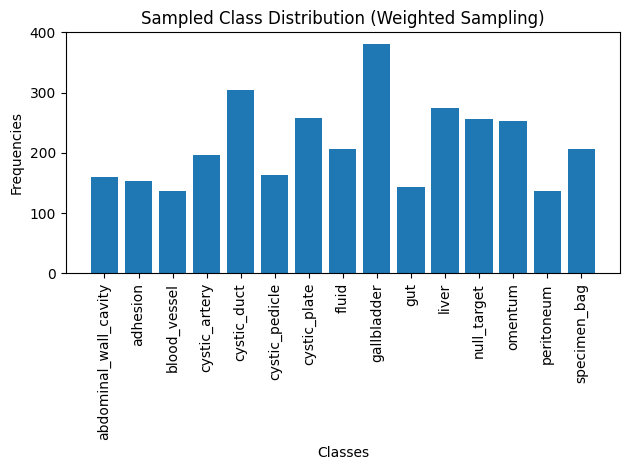

In [49]:
# Calculate and print the frequencies
print("Sampled Class Frequencies in an Epoch:")
for cls, count in class_counts.items():
    print(f"Class {cls}: {count}")



classes, frequencies = zip(*sorted(class_counts.items()))
plt.bar(classes, frequencies)
plt.xlabel("Classes")
plt.ylabel("Frequencies")
plt.title("Sampled Class Distribution (Weighted Sampling)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
